## 1. Install Dependencies

In [1]:
pip install tensorflow opencv-python numpy matplotlib scikit-learn Pillow tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt

2023-12-05 10:41:18.172139: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 10:41:18.192725: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 10:41:18.294895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 10:41:18.294975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 10:41:18.311482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/home/vipul/.local/lib/python3.10/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [4]:
#pip list

In [5]:
# For using GPUS
gpus = tf.config.experimental.list_physical_devices('GPU') # Listing GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2023-12-05 10:41:20.017443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 10:41:20.072551: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 2. Load the Data

In [6]:
import numpy as np
import cv2
from struct import unpack
from tqdm import tqdm

#### Removing corrupt images

In [7]:
# Your root directory containing subdirectories for each class
# root_img = 'Dataset'

# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }

# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()
    
#     def decode(self):
#         data = self.img_data
#         while True:
#             marker, = unpack(">H", data[0:2])
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2 + lenchunk:]            
#             if len(data) == 0:
#                 break    

# # JPEG processing loop
# bads = []

# for class_dir in os.listdir(root_img):
#     class_path = os.path.join(root_img, class_dir)
#     if os.path.isdir(class_path):
#         for img in tqdm(os.listdir(class_path)):
#             image_path = os.path.join(class_path, img)
#             jpeg_image = JPEG(image_path)
#             try:
#                 jpeg_image.decode()
#             except:
#                 bads.append((img, class_dir)) 

# # Function to remove bad images
# def remove_bad_images(bads):
#     for name, class_dir in bads:
#         os.remove(os.path.join(root_img, class_dir, name))

# # Remove bad images for each class
# for class_dir in ['benign', 'malignant']:
#     remove_bad_images([(name, class_dir) for name, dir_ in bads if dir_ == class_dir])

In [8]:
data = tf.keras.utils.image_dataset_from_directory('Dataset',shuffle=True)

Found 9999 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

## 3. Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Set the path to your dataset directory
data_directory = 'Dataset'

# Create an ImageDataGenerator with augmentation configurations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an image dataset without data augmentation for validation and test sets
data_no_augmentation = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(256, 256),
    batch_size=64,
    label_mode='binary',  # or 'categorical' if you have more than two classes
    shuffle=True,
    seed=42,
    validation_split=0.1,  # Using 10% for validation
    subset='validation'
)

# Split the data into validation and test sets
val_size = 1000  # Adjust as needed
test_size = 1000  # Adjust as needed
val = data_no_augmentation.take(val_size)
test = data_no_augmentation.skip(val_size).take(test_size)

# Create an image dataset with data augmentation for the training set
train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    image_size=(256, 256),
    batch_size=64,
    label_mode='binary',  # or 'categorical' if you have more than two classes
    shuffle=True,
    seed=42,
    validation_split=0.1,  # Using 10% for validation
    subset='training'
)

# Apply data augmentation to the training set within the TensorFlow pipeline
augmented_data = train_data.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

# Normalize pixel values to the range [0, 1]
augmented_data_normalized = augmented_data.map(lambda x, y: (x / 255, y))

# Now, 'augmented_data_normalized' contains the augmented and normalized images for the training set


Found 9999 files belonging to 2 classes.
Using 999 files for validation.
Found 9999 files belonging to 2 classes.
Using 9000 files for training.


In [12]:
print(f"Training Dataset size :{augmented_data}")
print(f"Validating Dataset size :{val}")
print(f"Testing Dataset size :{test}")

Training Dataset size :<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Validating Dataset size :<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Testing Dataset size :<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [13]:
# Get a batch from the Iterator
batch = augmented_data_normalized.as_numpy_iterator().next()

In [14]:
#Images represnted as Np array
batch[0].shape

(64, 256, 256, 3)

In [15]:
#Class 1 : Malignant
#Class 0 : Benign
batch[1]

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

/usr/lib/python3/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


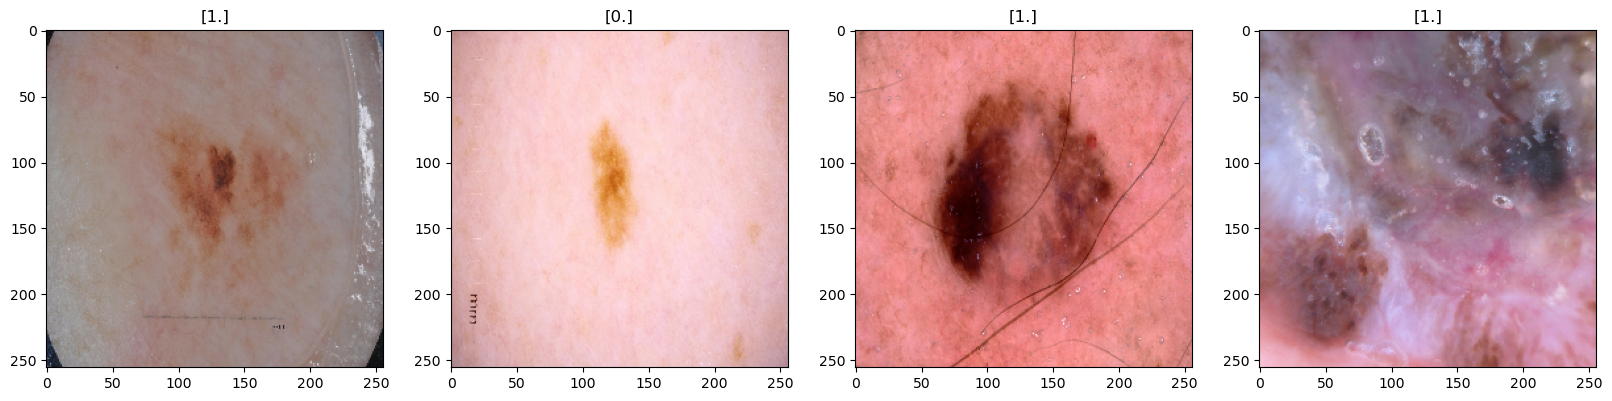

In [16]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 4. Building the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4)) # --> Apply if Overfitting

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.compile(optimizer=SGD(learning_rate=0.01), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) --> Apply this if Overfitting

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

## 5. Training the Model

In [23]:
logdir = "logs"

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [25]:
train_data = augmented_data_normalized

In [26]:
with tf.device('/GPU:0'):
    hist = model.fit(train_data, epochs=2, validation_data=val, callbacks=[tensorboard_callback]) 

Epoch 1/2
141/141 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.6538

2023-12-05 10:44:21.208130: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 50331904 bytes after encountering the first element of size 50331904 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


141/141 [==============================] - 183s 1s/step - loss: 0.6975 - accuracy: 0.6538 - val_loss: 242.3617 - val_accuracy: 0.4835
Epoch 2/2
141/141 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.7364

2023-12-05 10:47:25.082739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 50331904 bytes after encountering the first element of size 50331904 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


141/141 [==============================] - 184s 1s/step - loss: 0.5494 - accuracy: 0.7364 - val_loss: 401.6647 - val_accuracy: 0.4845


## 6. Plotting Performance

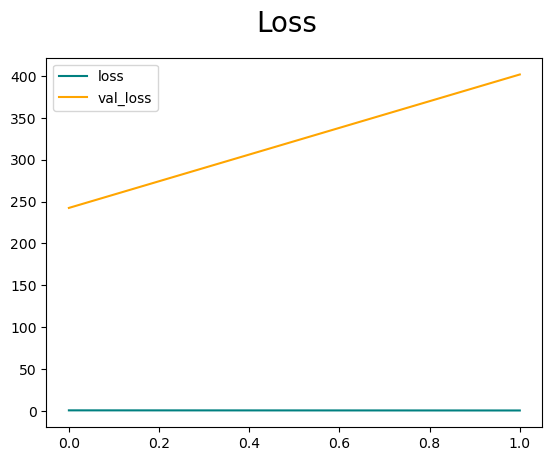

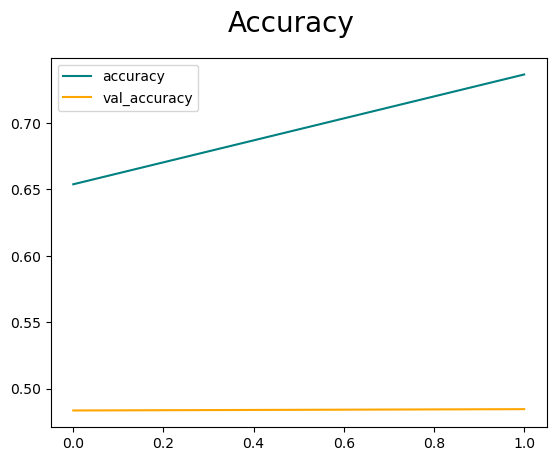

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


## 7. Evaluating the Performance

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report,confusion_matrix

In [29]:
# Evaluate the model
Y_pred = model.predict(test)
y_pred = np.round(Y_pred)

ValueError: Expected input data to be non-empty.

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
y_true_list = []
y_pred_prob_list = []

# Iterate over batches
for batch in test.as_numpy_iterator():
    X, y = batch
    # yhat = model.predict(X).flatten()  # Flatten to get a 1D array
    yhat = model.predict(X, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0).flatten()
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    # Append true labels and predicted probabilities to the lists
    y_true_list.extend(y)
    y_pred_prob_list.extend(yhat)

# Convert probabilities to binary labels using a threshold (e.g., 0.5)
y_pred_list = (np.array(y_pred_prob_list) > 0.5).astype(int)

# Print classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_list, y_pred_list))
print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list))

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

## 8. Testing the Model

In [ ]:
img = cv2.imread('Testing/benign3.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
resize.shape

In [ ]:
np.expand_dims(resize, 0).shape

In [ ]:
yhat = model.predict(np.expand_dims(resize/255 , 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5 :
    print(f'Malignant')
elif yhat < 0.5 :
    print(f'Benign')

## 9. Saving the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','test.keras'))

In [ ]:
new_model = load_model('models/skin_cnn_4_79%.keras')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))